In [ ]:
## Using a preprocessing procedure based on
## http://naturalistic-data.org/features/notebooks/Preprocessing.html
## this is specificly for naturalistic data (like movies, audio scripts etc.)
# the First cells are ment to actual denoising + saving a new nifti file. Then - saving the file in hdf5 format
## (should be easier/faster to load). Last part in this script is generating parcellation of 50 ROIs and save
## timeserires for each of them in .csv file. 
## Parcellation is taken from: https://neurovault.org/collections/2099/

In [1]:
%config Completer.use_jedi = False

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nltools.mask import expand_mask

def make_motion_covariates(mc, tr):
    z_mc = zscore(mc)
    all_mc = pd.concat([z_mc, z_mc**2, z_mc.diff(), z_mc.diff()**2], axis=1)
    all_mc.fillna(value=0, inplace=True)
    return Design_Matrix(all_mc, sampling_freq=1/tr)

/gpfs/ysm/project/joormann/oad4/conda_envs/naturlistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [5]:
base_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep'
scan = '3' # scan number
fwhm=6
tr = 1
outlier_cutoff = 3

file_list = [x for x in glob.glob(os.path.join(base_dir, f'*/ses-{scan}/func/*MNI*preproc*gz')) if 'denoised' not in x] 
for f in file_list:
    print(f)
    sub = os.path.basename(f).split('_')[0]
    data = Brain_Data(f)
    smoothed = data.smooth(fwhm=fwhm)

    spikes = smoothed.find_spikes(global_spike_cutoff=outlier_cutoff, diff_spike_cutoff=outlier_cutoff)
    covariates = pd.read_csv(glob.glob(os.path.join(base_dir, sub,f'ses-{scan}', 'func', '*confounds*tsv'))[0], sep='\t')
    mc = covariates[['trans_x','trans_y','trans_z','rot_x', 'rot_y', 'rot_z']]
    mc_cov = make_motion_covariates(mc, tr)
    csf = covariates['csf'] # Use CSF from fmriprep output
    dm = Design_Matrix(pd.concat([csf, mc_cov, spikes.drop(labels='TR', axis=1)], axis=1), sampling_freq=1/tr)
    dm = dm.add_poly(order=2, include_lower=True) # Add Intercept, Linear and Quadratic Trends

    smoothed.X = dm
    stats = smoothed.regress()
    stats['residual'].data = np.float32(stats['residual'].data) # cast as float32 to reduce storage space
    stats['residual'].write(os.path.join(base_dir, sub,'ses-3', 'func', f'{sub}_ses-{scan}_denoise_smooth{fwhm}mm_task-movie_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'))

/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1237/ses-3/func/sub-1237_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1099/ses-3/func/sub-1099_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1272/ses-3/func/sub-1272_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1350/ses-3/func/sub-1350_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1271/ses-3/func/sub-1271_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1269/ses-3/func/sub-1269_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/gpfs/gibbs/pi/levy_ifat/Or/

In [7]:
data_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep'

scan = 'ses-3'
file_list = glob.glob(os.path.join(data_dir, '*',f'{scan}', 'func', f'*denoise*nii.gz'))
file_list
for f in file_list:
    data = Brain_Data(f)
    data.write(f"{f.split('.nii.gz')[0]}.hdf5")

/gpfs/ysm/project/joormann/oad4/conda_envs/naturlistic/lib/python3.7/site-packages/deepdish/io/hdf5io.py:251: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


## Extract data voxelwise

In [10]:
import nilearn

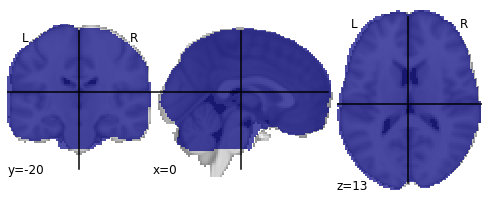

In [11]:
# create an average mask
mask_all = glob.glob('/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-*/ses-*/func/sub-*_ses-3_task-movie_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')
# mean of all masks
group_mask = nilearn.image.mean_img(mask_all)
# threshold the mask a bit
group_mask = nilearn.image.math_img("a>=1", a=group_mask)
nilearn.plotting.plot_roi(group_mask)

In [12]:
data_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/results/voxelwiseTS'
base_dir = '/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep'

scan = 'ses-3'
file_list = glob.glob(os.path.join(base_dir, '*',f'{scan}', 'func', f'*denoise*hdf5'))
for f in file_list[0:2]:
    print(f)
    sub = os.path.basename(f).split('_')[0]
    print(sub)
    data = Brain_Data(f)
    np.save(os.path.join(data_dir, f"{sub}_{scan}_voxelWise" ), data.data)


/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1237/ses-3/func/sub-1237_ses-3_denoise_smooth6mm_task-movie_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5
sub-1237
/gpfs/gibbs/pi/levy_ifat/Or/RCF_clips/derivatives/fmriprep/sub-1099/ses-3/func/sub-1099_ses-3_denoise_smooth6mm_task-movie_space-MNI152NLin2009cAsym_desc-preproc_bold.hdf5
sub-1099


In [18]:
data.data.shape

(1022, 238955)

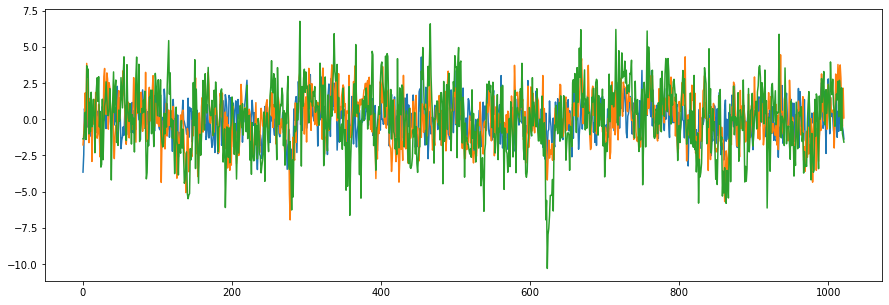

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(data.data[:,50])
plt.plot(data.data[:,500])
plt.plot(data.data[:,5000])